In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from kan import *
from kan.utils import ex_round
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from time import time
torch.set_default_dtype(torch.float64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [2]:
# Step 1: Load the Data
train_path = 'chf_train.csv'
test_path = 'chf_valid.csv'
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# Step 2: Prepare the Data
x_train = train_data.iloc[:, [0, 1, 2, 3, 4, 5]].values  # Input columns (1-6)
y_train = train_data.iloc[:, [6]].values  # Input columns (1-6)
x_test = test_data.iloc[:, [0, 1, 2, 3, 4, 5]].values  # Input columns (1-6)
y_test = test_data.iloc[:, [6]].values  # Input columns (1-6)

# Step 3: Min-Max Scaling
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_train = scaler_X.fit_transform(x_train)
X_test = scaler_X.transform(x_test)
Y_train = scaler_Y.fit_transform(y_train.reshape(-1, 1)).flatten()
Y_test = scaler_Y.transform(y_test.reshape(-1, 1)).flatten()

# Step 5: Convert to Torch Tensors and Create Dataset Format
train_input = torch.tensor(X_train, dtype=torch.double)
train_label = torch.tensor(Y_train, dtype=torch.double).unsqueeze(1)

test_input = torch.tensor(X_test, dtype=torch.double)
test_label = torch.tensor(Y_test, dtype=torch.double).unsqueeze(1)

# Creating the dataset dictionary
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}

# Checking the shape of the tensors
print(dataset['train_input'].shape, dataset['train_label'].shape)
print(dataset['test_input'].shape, dataset['test_label'].shape)

torch.Size([16090, 6]) torch.Size([16090, 1])
torch.Size([5363, 6]) torch.Size([5363, 1])


In [3]:
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[6,6,1], grid=3, k=3, seed=42, device=device)

checkpoint directory created: ./model
saving model version 0.0


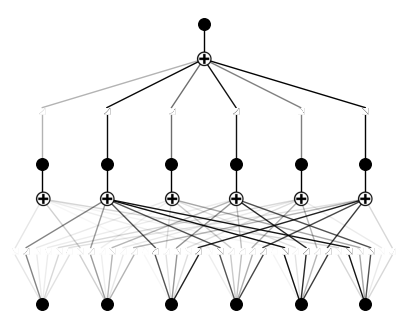

In [4]:
# plot KAN at initialization
model(dataset['train_input'])
model.plot()

In [5]:
# train the model
model.fit(dataset, opt="LBFGS", steps=100, lamb=0.001)

| train_loss: 2.25e-02 | test_loss: 1.95e-02 | reg: 2.74e+00 | : 100%|█| 100/100 [06:17<00:00,  3.77

saving model version 0.1


{'train_loss': [array(0.03901857),
  array(0.03163008),
  array(0.02550597),
  array(0.02446194),
  array(0.0232572),
  array(0.02321571),
  array(0.02327004),
  array(0.02337924),
  array(0.02341414),
  array(0.02337952),
  array(0.02341569),
  array(0.02333854),
  array(0.02344377),
  array(0.02343925),
  array(0.02332992),
  array(0.02327772),
  array(0.02332134),
  array(0.02328391),
  array(0.02332063),
  array(0.02329516),
  array(0.02329607),
  array(0.02322485),
  array(0.02324309),
  array(0.02318544),
  array(0.02318794),
  array(0.02321067),
  array(0.02320149),
  array(0.02315509),
  array(0.02313183),
  array(0.02307134),
  array(0.02308552),
  array(0.02309339),
  array(0.02309629),
  array(0.02306548),
  array(0.02302462),
  array(0.02296125),
  array(0.02293295),
  array(0.02295172),
  array(0.02296322),
  array(0.02300877),
  array(0.02301539),
  array(0.0230203),
  array(0.02300233),
  array(0.02300376),
  array(0.02301019),
  array(0.02305447),
  array(0.02313591),
 

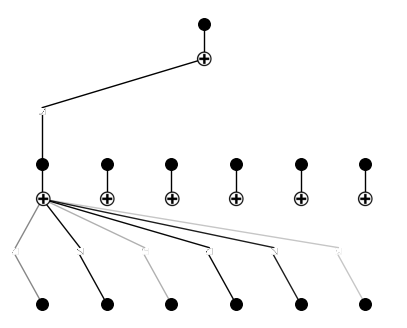

In [6]:
model.plot()

saving model version 0.2


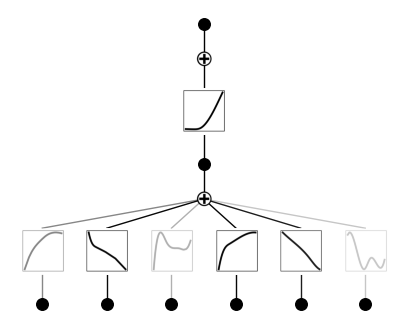

In [7]:
model = model.prune()
model.plot()

In [8]:
model.fit(dataset, opt="LBFGS", steps=100)

| train_loss: 1.70e-02 | test_loss: 1.45e-02 | reg: 8.61e+00 | : 100%|█| 100/100 [02:27<00:00,  1.48

saving model version 0.3


{'train_loss': [array(0.04682627),
  array(0.04307497),
  array(0.03489049),
  array(0.03090908),
  array(0.02899332),
  array(0.02269393),
  array(0.02118098),
  array(0.02085649),
  array(0.02041961),
  array(0.01995696),
  array(0.01977879),
  array(0.01941809),
  array(0.01883739),
  array(0.01795075),
  array(0.01763662),
  array(0.01741932),
  array(0.01733999),
  array(0.01730721),
  array(0.01726563),
  array(0.01720085),
  array(0.01717696),
  array(0.01712465),
  array(0.0171076),
  array(0.01706477),
  array(0.01704874),
  array(0.01707701),
  array(0.01706603),
  array(0.01705038),
  array(0.01704293),
  array(0.01702944),
  array(0.01705961),
  array(0.01704841),
  array(0.01703998),
  array(0.01703275),
  array(0.01702808),
  array(0.01708675),
  array(0.01706864),
  array(0.01705602),
  array(0.01704599),
  array(0.01703487),
  array(0.01707941),
  array(0.01706473),
  array(0.01705468),
  array(0.01702857),
  array(0.01701802),
  array(0.01706127),
  array(0.01703515),


In [9]:
model = model.refine(5)
model.fit(dataset, opt="LBFGS", steps=100)

saving model version 0.4


| train_loss: 1.63e-02 | test_loss: 1.40e-02 | reg: 7.83e+00 | : 100%|█| 100/100 [02:43<00:00,  1.63

saving model version 0.5


{'train_loss': [array(0.016657),
  array(0.01655632),
  array(0.01646679),
  array(0.0164245),
  array(0.01639996),
  array(0.01637782),
  array(0.01636865),
  array(0.01635377),
  array(0.01633498),
  array(0.01632303),
  array(0.01631743),
  array(0.01631292),
  array(0.01630908),
  array(0.01630704),
  array(0.01630526),
  array(0.01630311),
  array(0.01630071),
  array(0.01629964),
  array(0.01629838),
  array(0.01629727),
  array(0.01629603),
  array(0.0162953),
  array(0.0162945),
  array(0.01629429),
  array(0.01629401),
  array(0.01629359),
  array(0.01629337),
  array(0.01629322),
  array(0.01629308),
  array(0.01629279),
  array(0.01629242),
  array(0.01629235),
  array(0.01629226),
  array(0.01629219),
  array(0.01629216),
  array(0.01629222),
  array(0.01629217),
  array(0.01629215),
  array(0.01629211),
  array(0.01629209),
  array(0.01629221),
  array(0.01629217),
  array(0.01629212),
  array(0.01629208),
  array(0.01629204),
  array(0.01629216),
  array(0.0162921),
  arr

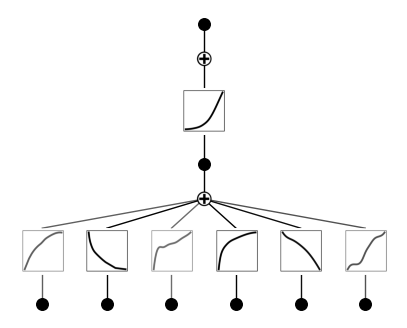

In [10]:
model.plot()

In [11]:
model = model.refine(10)
model.fit(dataset, opt="LBFGS", steps=100)

saving model version 0.6


| train_loss: 1.59e-02 | test_loss: 1.36e-02 | reg: 8.05e+00 | : 100%|█| 100/100 [03:59<00:00,  2.40

saving model version 0.7


{'train_loss': [array(0.01617741),
  array(0.01614951),
  array(0.0161237),
  array(0.01610183),
  array(0.01608086),
  array(0.01606557),
  array(0.0160581),
  array(0.0160563),
  array(0.01605502),
  array(0.01605364),
  array(0.01605234),
  array(0.01605045),
  array(0.01604888),
  array(0.0160473),
  array(0.0160452),
  array(0.0160435),
  array(0.01604157),
  array(0.0160405),
  array(0.01603945),
  array(0.01603806),
  array(0.01604019),
  array(0.0160393),
  array(0.01603836),
  array(0.01603749),
  array(0.0160356),
  array(0.01604049),
  array(0.01603955),
  array(0.01603912),
  array(0.01603869),
  array(0.0160383),
  array(0.01603796),
  array(0.01603745),
  array(0.01603639),
  array(0.01603431),
  array(0.01603105),
  array(0.01603945),
  array(0.01603858),
  array(0.01603814),
  array(0.01603795),
  array(0.0160378),
  array(0.01603724),
  array(0.01603683),
  array(0.01603539),
  array(0.01603042),
  array(0.01602181),
  array(0.01604425),
  array(0.0160416),
  array(0.0

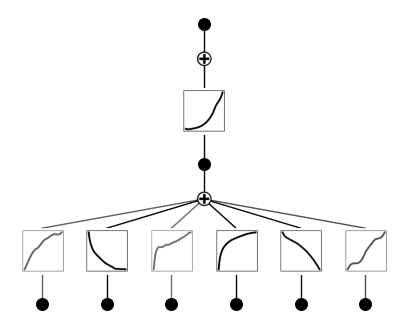

In [12]:
model.plot()

In [13]:
model = model.refine(25)
model.fit(dataset, opt="LBFGS", steps=100)

saving model version 0.8


| train_loss: 1.49e-02 | test_loss: 1.33e-02 | reg: 8.16e+00 | : 100%|█| 100/100 [08:06<00:00,  4.87

saving model version 0.9


{'train_loss': [array(0.01559312),
  array(0.01547205),
  array(0.0153548),
  array(0.01527342),
  array(0.01521949),
  array(0.01517734),
  array(0.0151047),
  array(0.01504164),
  array(0.01498899),
  array(0.01495348),
  array(0.01495426),
  array(0.01493337),
  array(0.01492121),
  array(0.0149159),
  array(0.01491212),
  array(0.0149193),
  array(0.01491206),
  array(0.01490613),
  array(0.01490192),
  array(0.0148989),
  array(0.01490544),
  array(0.01489785),
  array(0.01489134),
  array(0.01488904),
  array(0.01488613),
  array(0.0148941),
  array(0.01488693),
  array(0.0148824),
  array(0.01488011),
  array(0.01487852),
  array(0.01488794),
  array(0.01488125),
  array(0.01487636),
  array(0.01487461),
  array(0.0148732),
  array(0.01488109),
  array(0.01487285),
  array(0.01486797),
  array(0.01486582),
  array(0.01486487),
  array(0.01487452),
  array(0.01486953),
  array(0.01486609),
  array(0.01486474),
  array(0.01486388),
  array(0.01487337),
  array(0.0148693),
  array(

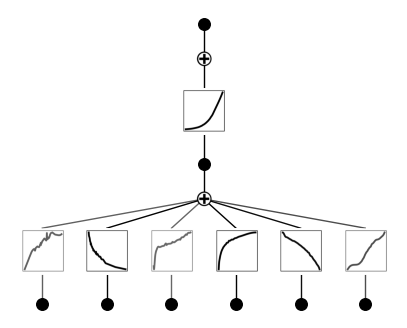

In [14]:
model.plot()

In [15]:
X_test = dataset['test_input']  # Shape: (n_samples, 6)
Y_test = dataset['test_label']  # Shape: (n_samples,)

Y_pred_KAN = model(X_test)

In [17]:
X_test_np = X_test.cpu().numpy() if X_test.is_cuda else X_test.numpy()
Y_test_np = Y_test.cpu().numpy() if Y_test.is_cuda else Y_test.numpy()
Y_test_pred_np = Y_pred_KAN.cpu().detach().numpy() if Y_pred_KAN.is_cuda else Y_pred_KAN.detach().numpy()

# Combine X_test, Y_test, and Y_test_pred into a single DataFrame
data = np.hstack((X_test_np, Y_test_np.reshape(-1, 1), Y_test_pred_np.reshape(-1, 1)))
columns = [f"x{i+1}" for i in range(X_test_np.shape[1])] + ["y_test", "y_test_pred_KAN"]

# Create a DataFrame
df = pd.DataFrame(data, columns=columns)

# Export the DataFrame to a CSV file
output_file = "KAN_predictions.csv"
df.to_csv(output_file, index=False)

print(f"Predictions exported to {output_file}")


Predictions exported to KAN_predictions.csv


In [26]:
Y_pred_KAN_np = Y_pred_KAN.detach().numpy()
y_pred_KAN = scaler_Y.inverse_transform(Y_pred_KAN_np)
#y_test = scaler_Y.inverse_transform(Y_test.reshape(-1, 1))

KAN_mae = mean_absolute_error(y_test, y_pred_KAN)
KAN_mape = np.mean(np.abs((y_test - y_pred_KAN) / y_test)) * 100  # Mean Absolute Percentage Error
KAN_mse = mean_squared_error(y_test, y_pred_KAN)
KAN_rmse = np.sqrt(KAN_mse)  # Root Mean Squared Error
KAN_rmspe = np.sqrt(np.mean(np.square((y_test - y_pred_KAN) / y_test))) * 100  # Root Mean Square Percentage Error
KAN_r2 = r2_score(y_test, y_pred_KAN)

# Printing the metrics
print(f"KAN Mean Absolute Error (MAE): {KAN_mae:.4f}")
print(f"KAN Mean Absolute Percentage Error (MAPE): {KAN_mape:.4f}%")
print(f"KAN Mean Squared Error (MSE): {KAN_mse:.4f}")
print(f"KAN Root Mean Squared Error (RMSE): {KAN_rmse:.4f}")
print(f"KAN Root Mean Square Percentage Error (RMSPE): {KAN_rmspe:.4f}%")
print(f"KAN R-squared (R2): {KAN_r2:.4f}")

KAN Mean Absolute Error (MAE): 120.0505
KAN Mean Absolute Percentage Error (MAPE): 8.3244%
KAN Mean Squared Error (MSE): 30939.3565
KAN Root Mean Squared Error (RMSE): 175.8959
KAN Root Mean Square Percentage Error (RMSPE): 11.7920%
KAN R-squared (R2): 0.9822


In [27]:
SYMBOLIC_LIB.keys()

dict_keys(['x', 'x^2', 'x^3', 'x^4', 'x^5', '1/x', '1/x^2', '1/x^3', '1/x^4', '1/x^5', 'sqrt', 'x^0.5', 'x^1.5', '1/sqrt(x)', '1/x^0.5', 'exp', 'log', 'abs', 'sin', 'cos', 'tan', 'tanh', 'sgn', 'arcsin', 'arccos', 'arctan', 'arctanh', '0', 'gaussian'])

In [28]:
mode = "auto" # "manual"
t_init = time()

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin')
    model.fix_symbolic(0,1,0,'x^2')
    model.fix_symbolic(1,0,0,'exp')
elif mode == "auto":
    # automatic mode
    lib = ['x', 'x^0.5','x^2','x^3','x^4','1/x','1/x^0.5','1/x^2','1/x^3','1/x^4','exp','log','sqrt','tanh','sin','tan','abs', 'gaussian', 'sgn', '0']
    model.auto_symbolic(lib=None, weight_simple=0) # Lib none uses all of symbolic library, weight_simple asks for function fit complexity, 0 is complex and requires time
t_conv = time() - t_init
print("The conversion time is:",t_conv/60,"minutes.")

fixing (0,0,0) with cos, r2=0.9719918064058931, c=2
fixing (0,1,0) with arctanh, r2=0.9962974796739538, c=4
fixing (0,2,0) with tan, r2=0.9579397150523021, c=3
fixing (0,3,0) with tan, r2=0.9987631599927111, c=3
fixing (0,4,0) with tan, r2=0.9985227665471312, c=3
fixing (0,5,0) with gaussian, r2=0.9964518941298861, c=3
fixing (1,0,0) with tanh, r2=0.9997345775314551, c=3
saving model version 0.10
The conversion time is: 15.024429961045582 minutes.


In [29]:
output = ex_round(model.symbolic_formula()[0][0], 4)
print('After rounding, the formula is:\n',output)

output_type = type(output)
print('output type is', output_type)

After rounding, the formula is:
 0.6975 - 0.6996*tanh(0.6936*cos(1.5813*x_1 - 4.589) - 0.0589*tan(2.7642*x_3 - 4.5831) - 0.3475*tan(2.212*x_4 - 1.4029) + 0.6529*tan(0.6*x_5 + 9.9968) + 0.9714*atanh(1.0*x_2 - 0.992) + 1.3965 + 0.4367*exp(-6.1413*(0.2107 - x_6)**2))
output type is <class 'sympy.core.add.Add'>


In [30]:
# Assuming your symbolic expression (e.g., Y = x_1 + x_2 * x_3 + ...) 
# Replace this with your actual symbolic expression
x_1, x_2, x_3, x_4, x_5, x_6 = symbols('x_1 x_2 x_3 x_4 x_5 x_6') 
symbolic_expr = model.symbolic_formula()[0][0]

# Extract test data inputs and labels
X_test = dataset['test_input']  # Shape: (n_samples, 6)
Y_test = dataset['test_label']  # Shape: (n_samples,)

# List of symbols to map test_input to the symbolic expression
variables = [x_1, x_2, x_3, x_4, x_5, x_6]

In [31]:
# Evaluate symbolic expression for each row in X_test
Y_pred_sym = []
for row in X_test:
    # Create a dictionary to map symbolic variables to values
    inputs = {var: value for var, value in zip(variables, row)}
    # Evaluate the symbolic expression and use evalf() to get a float value
    Y_pred_sym.append(float(symbolic_expr.subs(inputs).evalf()))

In [32]:
# Convert predictions to NumPy array and reshape 
Y_pred_sym = np.array(Y_pred_sym).reshape(-1, 1)

# Inverse scale predictions and ground truth
y_pred_sym = scaler_Y.inverse_transform(Y_pred_sym)
#y_test = scaler_Y.inverse_transform(Y_test.reshape(-1, 1))

In [33]:
# Compute R^2 score
sym_mae = mean_absolute_error(y_test, y_pred_sym)
sym_mape = np.mean(np.abs((y_test - y_pred_sym) / y_test)) * 100  # Mean Absolute Percentage Error
sym_mse = mean_squared_error(y_test, y_pred_sym)
sym_rmspe = np.sqrt(np.mean(np.square((y_test - y_pred_sym) / y_test))) * 100  # Root Mean Square Percentage Error
sym_rmse = np.sqrt(sym_mse)  # Root Mean Squared Error
sym_r2 = r2_score(y_test, y_pred_sym)

# Printing the metrics
print(f"Symbolic Mean Absolute Error (MAE): {sym_mae:.4f}")
print(f"Symbolic Mean Absolute Percentage Error (MAPE): {sym_mape:.4f}%")
print(f"Symbolic Mean Squared Error (MSE): {sym_mse:.4f}")
print(f"Symbolic Root Mean Squared Error (RMSE): {sym_rmse:.4f}")
print(f"Symbolic Root Mean Square Percentage Error (RMSPE): {sym_rmspe:.4f}%")
print(f"Symbolic R-squared (R2): {sym_r2:.4f}")

Symbolic Mean Absolute Error (MAE): 132.7008
Symbolic Mean Absolute Percentage Error (MAPE): 8.7622%
Symbolic Mean Squared Error (MSE): 42276.9647
Symbolic Root Mean Squared Error (RMSE): 205.6136
Symbolic Root Mean Square Percentage Error (RMSPE): 12.5189%
Symbolic R-squared (R2): 0.9757
